# Exercise 1.8

**Continuation of Exercise 1.7** where it was considered a portfolio of 1-year term life insurance independent policies from the file `LIFEinsurance.csv` that specifies age and insured amount for each policy, using the mortality table in the file `mortality.csv` with the additional benefit of twice the insured amount in case of accidental death, assuming that 1 out of 10 deaths is accidental (no matter the age). Build a collective risk model that approximates the results obtained by the individual risk model in Exercise 1.7.

In [37]:
using Distributions, Statistics, CSV, DataFrames, Plots

### Data input

In [38]:
mort = DataFrame(CSV.File("mortality.csv")) # mortality table

,AGE,qx
,Int64,Float64
1,0,0.00115
2,1,0.00115
3,2,0.001155
4,3,0.00116
5,4,0.00117
6,5,0.001175
7,6,0.001185
8,7,0.001195
9,8,0.001205


In [39]:
k = 1/10 # proportion of deaths caused by an accident
q = Dict(mort.AGE .=> mort.qx); # Dictionary: a function that maps age -> qx

In [40]:
policy = DataFrame(CSV.File("LIFEinsurance.csv")) # life insurance portfolio

,AGE,INSAMOUNT
,Int64,Float64
1,49,9.2
2,26,3.1
3,59,10.7
4,46,12.6
5,30,5.1
6,38,8.7
7,36,5.9
8,47,6.2
9,24,2.1


### Indidivudual risk model

For each insurance policy $j\in\{1,\ldots,r\}$ (in this example $r=10,000$) it is defined an indivual claim random variable $X_j$ as follows: 

$$X_j = c_jD_j(1+A_j)$$
where:

$c_j =$ insured amount for policy $j$

$q_j =$ mortality rate for policy $j$

$D_j \sim$ *Bernoulli* random variable with parameter $0<q_j<1$

$A_j \sim$ *Bernoulli* random variable with parameter $\kappa=\frac{1}{10}$ (proportion of accidental deaths)

The insurance portolio individual claims are represented by a collection of $r$ random variables $\{X_1,\ldots,X_r\}$ where $\text{Ran}\,X_j=\{0,c_j,2c_j\}$ for each $j\in\{1,\ldots,r\}.$ Therefore, under an individual risk model the **total claims** random variable is given by:

$$S = X_1 + \cdots + X_r = \sum_{j\,=\,1}^{r}c_jD_j(1+A_j)$$

The theoretical mean and variance of $S$ accordingly to to the individual risk model, considering all $D_j$ and $A_j$ independent random variables, are given by:

$$\mu_S = \mathbb{E}(S) = \mathbb{E}\left(\sum_{j\,=\,1}^r c_jD_j(1+A_j)\right) = \sum_{j\,=\,1}^r c_jq_j(1+\kappa)$$

$$\sigma_S^2 = \mathbb{V}(S) = \mathbb{V}\left(\sum_{j\,=\,1}^r c_jD_j(1+A_j)\right) = \sum_{j\,=\,1}^r c_j^2q_j[1+3\kappa-q_j(1+\kappa)^2]$$

Let's now define a random variable $N$ to count the number of claims: 

$$N = \sum_{j\,=\,1}^{r}\mathbb{1}_{\{X_j\,>\,0\}} = \sum_{j\,=\,1}^{r}D_j$$

The theoretical mean and variance of $N$ accordingly to to the individual risk model are given by:

$$\mu_N = \mathbb{E}(N) = \mathbb{E}\left(\sum_{j\,=\,1}^r D_j\right) = \sum_{j\,=\,1}^r\mathbb{E}(D_j) = \sum_{j\,=\,1}^r q_j$$

$$\sigma_N^2 = \mathbb{V}(N) = \mathbb{V}\left(\sum_{j\,=\,1}^r D_j\right) = \sum_{j\,=\,1}^r\mathbb{V}(D_j) = \sum_{j\,=\,1}^r q_j(1-q_j)$$

where in the calculation of $\mathbb{V}(N)$ all the covariances $\mathbb{Cov}(D_i,D_j)=0$ for all $i\neq j$ since $D_1,\ldots,D_r$ are assumed independent in this excercise.

In [41]:
ES = 0.0
VS = 0.0
EN = 0.0
VN = 0.0
r = length(policy.AGE)
for j ∈ 1:r
    qj = q[policy.AGE[j]]
    cj = policy.INSAMOUNT[j]
    ES += (1 + k)*cj*qj # Same as ES = ES + (1 + k)*cj*qj
    VS += (cj^2) * qj * (1 + 3k - qj * (1 + k)^2) 
    EN += qj
    VN += qj * (1 - qj)
end
println("E(S) = ", ES)
println("V(S) = ", VS)
println("E(N) = ", EN)
println("V(N) = ", VN)

E(S) = 345.3497998500011
V(S) = 4202.942121519234
E(N) = 34.59349999999978
V(N) = 34.43467652314959


In [42]:
# Version using `Bernoulli` from the `Distributions` package
m = 100_000
S = zeros(m)
N = zeros(Int, m)
@time begin # The macro @time measures execution time
    for j ∈ 1:r
        Accident = rand(Bernoulli(k), m) # vector of size m
        Death = rand(Bernoulli(q[policy.AGE[j]]), m) # vector of size m
        N = N .+ Death
        S = S .+ (policy.INSAMOUNT[j] .* Death .* (1 .+ Accident))
    end
end

  6.958504 seconds (248.98 k allocations: 16.771 GiB, 9.43% gc time)


In [43]:
println("sim M(S) = ", median(S))
println("sim E(S) = ", mean(S))
println("sim V(S) = ", var(S))
println("sim E(N) = ", mean(N))
println("sim V(N) = ", var(N))
simVaR = quantile(S, 0.995)
println("VaR(0.995) = ", simVaR)

sim M(S) = 342.80000000000007
sim E(S) = 345.227915
sim V(S) = 4164.834248795262
sim E(N) = 34.5961
sim V(N) = 34.13036609366093
VaR(0.995) = 524.3005000000004


### Collective risk model

The counting random variable $N$ represents the *frequency* (total number of claims in a given period) and the random variable $Y$ represents the *severity* of any claim (in monetary units). The **total claims** random variable is now given by: 

$$S=Y_1 + \cdots + Y_N$$
where: $$N = \sum_{j\,=\,1}^{r}\mathbb{1}_{\{X_j\,>\,0\}} = \sum_{j\,=\,1}^{r}D_j$$ 

and $Y_1,Y_2,\ldots$ are iid as the severity random variable $Y.$ Clearly $\text{Ran}\,N=\{0,1,\ldots,r\}$ in this case. Since $D_1,\ldots,D_r$ are independent BUT not identically distributed, it is not guaranteed that the probability distibuton of $N$ is *Binomial* but we may wonder if there exists some sort of "average" value $0<q_N<1$ such that the probabilty distribution of $N$ could be fairly approximated by a *Binomial* model with parameters $r$ and $q_N.$ In such case it must be true that $\mathbb{E}(N)=rq_N=\mu_N=\sum_{j=1}^r q_j$ and therefore:

$$q_N = \frac{1}{r}\sum_{j\,=\,1}^r q_j$$

In [44]:
qN = EN / r

0.003459349999999978

Let's now compare the variance of a $\text{Binomial}(r, q_N)$ random variable and $\sigma_N^2$ obtained under the individual risk model:

In [45]:
r * qN * (1 - qN), VN

(34.47382897577478, 34.43467652314959)

Not exactly the same but probably fair enough. Remember that the collective risk model is an *approximation.* In terms of standard deviation, this approximation will use a frequency with slightly more variability, but less that 0.1% higher:

In [46]:
dif = 100 * (√(r * qN * (1 - qN) / VN) - 1) # in %
println(round(dif, digits = 2), "%")

0.06%


Let's now deal with severity. The random variable $Y_1$ represents the amount to be paid for the first (positive) claim, which may come out of any of the $r$ policies in the insurance portfolio, but considering that the policyholders have different probabilities of dying within a year, depending on their age. Let's assume that the probability of being the first claim is proportional to their probability of dying:

$$Y_1 = Z(1 + A)$$

where $A\sim\text{Bernoulli}(\kappa=\frac{1}{10})$ and:

$$\mathbb{P}(Z=c_j)=\frac{q_j}{\sum_{j=1}^r q_j}=\frac{q_j}{\mathbb{E}(N)}\,,\qquad j\in\{1,\ldots,r\}$$

For the second claim $Y_2$ we have a problem: $Y_2$ has dependence with $Y_1$ since the policy of the first claim should be now discarded since under this life insurance portfolio only one claim per policy is possible (sampling WITHOUT replacement), and therefore the usual assumption of $Y_1,Y_2,\ldots$ being iid is not striclty possible. But again, this is an *approximation* and under a sufficiently large insurance portfolio, the probability of picking twice or more times the same policy in sampling WITH replacement could be sufficiently low, with the advantage that in sampling WITH replacement the iid assumption for the severities would be correct.

Considering a set of $r$ different policies, in uniform sampling with replacement $n<r$ policies, what is the probability that all the $n$ policies are picked just once? This is just like the classical probability [*birthday problem*](https://en.wikipedia.org/wiki/Birthday_problem)

$$\frac{\text{\# all different}}{\text{\# with replacement}} = \frac{r(r-1)\cdots(r-n+1)}{r^n} = \left(1-\frac{1}{r}\right)\left(1-\frac{2}{r}\right)\cdots\left(1-\frac{n-1}{r}\right)$$

Since in this exercise $\mathbb{E}(N)=34.59$ let's take $n=35$ and $r=10,000$

In [47]:
n, r = 35, 10_000
prod(1 .- collect(1:(n-1)) ./ r)

0.942170951915911

Eventhough in this case it would not be uniform sampling, the sampling probability for each policy is bounded above by:

$$\mathbb{P}(Z=c_j) \leq \frac{\max \{q_j:j=0,1,,\ldots,r\}}{\mathbb{E}(N)}$$

In [48]:
q[maximum(policy.AGE)] / EN

0.00036105048636304735

With an average value of:

In [49]:
q[Int(round(mean(policy.AGE)))] / EN

8.252995504935951e-5

And since the collective risk model is an approximation, we will assume for the severity that $Y_1, Y_2, \ldots$ are iid as a random variable $Y = Z(1+A)$ as defined above, and compare results with those obtained by the (more accurate) individual risk model:

In [50]:
qq = zeros(r)
for j ∈ 1:r
    qq[j] = q[policy.AGE[j]]
end
p = qq ./ sum(qq)
C = Categorical(p); # check this in the Distributions package

In [51]:
function simSeverity(n) # Severity simulator
    clients = rand(C, n)
    Z = policy.INSAMOUNT[clients]
    A = rand(Bernoulli(k), n)
    Y = Z .* (1 .+ A) # Y = (Y1,...,YN)
    return Y
end

simSeverity (generic function with 1 method)

And finally, the collective risk model simulation:

In [52]:
B = Binomial(r, qN)
m = 100_000
n = rand(B, m) # simulating frequency N
Sc = zeros(m) 
@time for i ∈ 1:m
        Sc[i] += sum(simSeverity(n[i]))
end

 15.623975 seconds (2.21 M allocations: 29.946 GiB, 14.10% gc time, 0.05% compilation time)


In [53]:
println("sim M(Sc) = ", median(Sc))
println("sim E(Sc) = ", mean(Sc))
println("sim V(Sc) = ", var(Sc))
println("sim VaR(0.995) = ", quantile(Sc, 0.995))

sim M(Sc) = 343.29999999999995
sim E(Sc) = 345.50422100000003
sim V(Sc) = 4207.7225547087055
sim VaR(0.995) = 524.7


Compare with individual risk model results:

In [54]:
println("sim M(S) = ", median(S))
println("sim E(S) = ", mean(S))
println("sim V(S) = ", var(S))
println("VaR(0.995) = ", simVaR)

sim M(S) = 342.80000000000007
sim E(S) = 345.227915
sim V(S) = 4164.834248795262
VaR(0.995) = 524.3005000000004


In this case the collective risk model simulation is taking longer than the individual risk model because of the Categorical simulation from the insured amounts, so let's analyze the severity simulator:

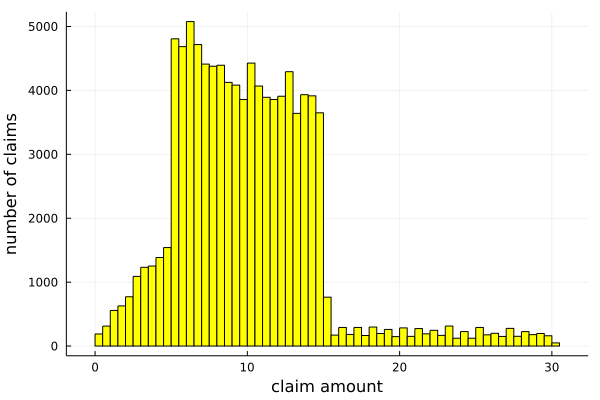

In [55]:
simY = simSeverity(100_000)
histogram(simY, legend = false, color = :yellow, xlabel = "claim amount", ylabel = "number of claims")

In [56]:
2 * maximum(policy.INSAMOUNT)

30.0

Does not look like any of the well-known and well-behaved probability distributions we are aware of! This is because of the insured amount distribution in this portfolio:

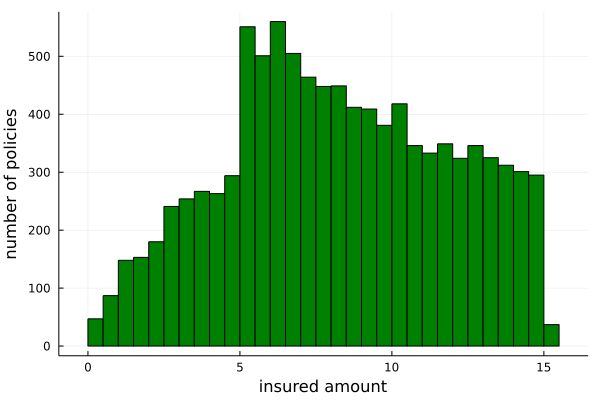

In [57]:
histogram(policy.INSAMOUNT, legend = false, color = :green, xlabel = "insured amount", ylabel = "number of policies")

What if we insist in fitting a well-known model for $Y$ in spite of this weird behaviour? Let's give it a try! 

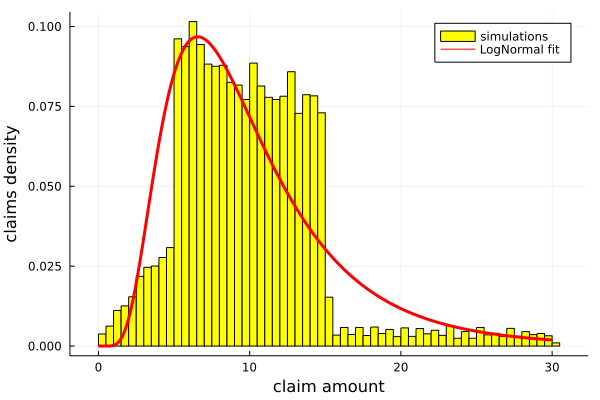

In [58]:
fitY = fit_mle(LogNormal, simY)
y = collect(range(0, 2 * maximum(policy.INSAMOUNT), length = 1_000))
histogram(simY, normalize = true, label = "simulations", 
          color = :yellow, xlabel = "claim amount", ylabel = "claims density")
plot!(y, pdf.(fitY, y), lw = 3, color = :red, label = "LogNormal fit")

Doesn't look very well, uh? Let's use it and see what happens:

In [59]:
B = Binomial(r, qN)
m = 100_000
n = rand(B, m)
Sc = zeros(m)
@time for i ∈ 1:m
        Sc[i] += sum(rand(fitY, n[i]))
end

  0.074747 seconds (698.98 k allocations: 43.440 MiB)


A lot faster, by far! But what about the results?

In [60]:
println("sim M(Sc) = ", median(Sc))
println("sim E(Sc) = ", mean(Sc))
println("sim V(Sc) = ", var(Sc))
println("sim VaR(0.995) = ", quantile(Sc, 0.995))

sim M(Sc) = 350.2936846875259
sim E(Sc) = 352.91838785316287
sim V(Sc) = 4814.953184586332
sim VaR(0.995) = 547.5418154966484


Compare with individual risk model results:

In [61]:
println("sim M(S) = ", median(S))
println("sim E(S) = ", mean(S))
println("sim V(S) = ", var(S))
println("VaR(0.995) = ", simVaR)

sim M(S) = 342.80000000000007
sim E(S) = 345.227915
sim V(S) = 4164.834248795262
VaR(0.995) = 524.3005000000004


Well, no surprise, right? Clearly it was not a good parametric fit for $Y$ but... what if we try a non-parametric simulation?

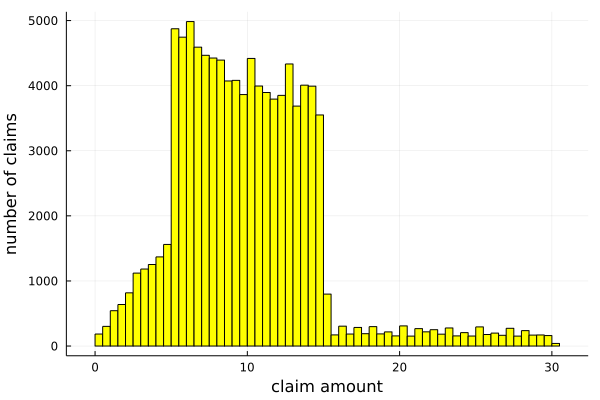

In [62]:
simSeverityNP(n) = quantile(simY, rand(n))
histogram(simSeverityNP(100_000), legend = false, color = :yellow, xlabel = "claim amount", ylabel = "number of claims")

Bingo! Let's how fast it is in simulating the collective risk model:

In [63]:
B = Binomial(r, qN)
m = 1_000
n = rand(B, m) # frequency
Sc = zeros(m)
@time for i ∈ 1:m
        Sc[i] += sum(simSeverityNP(n[i]))
end

  4.631882 seconds (8.98 k allocations: 763.738 MiB, 0.80% gc time)


Too slow just for 1,000 simulations! The problem is we used a very large number of simulations for `simY` (100,000) but to estimate a univariate density it would be more than enough with 1,000:

In [67]:
simY = simSeverity(1_000)
B = Binomial(r, qN)
m = 100_000
n = rand(B, m)
Sc = zeros(m)
@time for i ∈ 1:m
        Sc[i] += sum(simSeverityNP(n[i]))
end

  1.873648 seconds (898.98 k allocations: 851.334 MiB, 3.42% gc time)


Wonderful time! Let's check the results:

In [68]:
println("sim M(Sc) = ", median(Sc))
println("sim E(Sc) = ", mean(Sc))
println("sim V(Sc) = ", var(Sc))
println("sim VaR(0.995) = ", quantile(Sc, 0.995))

sim M(Sc) = 349.20438721063067
sim E(Sc) = 351.8153360378218
sim V(Sc) = 4320.476045434962
sim VaR(0.995) = 536.5515750631682


Compare with individual risk model results:

In [66]:
println("sim M(S) = ", median(S))
println("sim E(S) = ", mean(S))
println("sim V(S) = ", var(S))
println("VaR(0.995) = ", simVaR)

sim M(S) = 342.80000000000007
sim E(S) = 345.227915
sim V(S) = 4164.834248795262
VaR(0.995) = 524.3005000000004


Fair enough! Faster and pretty close to the individual risk model, in spite of all the approximative assumptions.